## Generative Adversarial Networks (GANs)

**Generative Adversarial Networks (GANs)** are a powerful class of generative models introduced by Ian Goodfellow in 2014. GANs are designed to **generate realistic data**, such as images, from random noise.

A GAN consists of two competing neural networks:

- **Generator (G)**: Learns to generate fake data that resemble the real data.
- **Discriminator (D)**: Learns to distinguish between real data and fake (generated) data.

The two networks play a **minimax game**:

$$
\min_G \max_D \ \mathbb{E}_{x \sim p_{\text{data}}(x)} [\log D(x)] + \mathbb{E}_{z \sim p(z)} [\log (1 - D(G(z)))]
$$

- $x$: a real data sample from the true distribution $p_{\text{data}}$
- $z$: a random noise vector (e.g., from $\mathcal{N}(0, I)$)
- $G(z)$: a fake data sample generated from noise
- $D(x)$: the discriminator's estimate of the probability that $x$ is real

##  Intuition

- The **generator** tries to "fool" the discriminator by generating increasingly realistic samples.
- The **discriminator** tries to become better at spotting fakes.
- Training continues until the discriminator can no longer distinguish real from fake — i.e., $D(G(z)) \approx 0.5$

#### Real-World Example: [ThisPersonDoesNotExist.com](https://thispersondoesnotexist.com)

The website [thispersondoesnotexist.com](https://thispersondoesnotexist.com) uses a **high-end GAN** (StyleGAN2 by NVIDIA) to generate ultra-realistic portraits of people who **do not exist**. Each time you refresh the page, a new human face is generated — not copied from a dataset, but imagined by the GAN.

This is a stunning example of the creative potential of GANs in the wild.


## Summary

| Component    | Role                                      |
|--------------|-------------------------------------------|
| Generator    | Maps noise $z$ to data-like outputs $G(z)$ |
| Discriminator| Distinguishes real data $x$ from fakes $G(z)$ |
| Training     | Adversarial, like a game between G and D   |

GANs have been used in **image generation**, **style transfer**, **super-resolution**, **data augmentation**, and **deepfake creation**.



### Demonstrating the Power of GANs on Fashion-MNIST

In this notebook, we will explore the power of **GANs** by training a model on the **Fashion-MNIST dataset**, a more challenging and modern alternative to the original MNIST digits dataset.

### What is the Fashion-MNIST Dataset?

Fashion-MNIST is a large-scale dataset of grayscale images of **clothing and accessories**. It was designed to serve as a **drop-in replacement for MNIST**, but with more visually complex and diverse content.

- **70,000** total images (60,000 training + 10,000 testing)
- Each image is **28×28 pixels**, grayscale
- **10 classes**, including:
  - *T-shirt/top*, *Trouser*, *Pullover*, *Dress*, *Coat*, *Sandal*, *Shirt*, *Sneaker*, *Bag*, *Ankle boot*
- Images are centered and size-normalized, making it a clean and standardized dataset

Fashion-MNIST is ideal for generative modeling because:
- It has **semantic structure** and more variability than MNIST digits
- Still remains **lightweight and quick to train on**
- Helps demonstrate how GANs learn visual distributions beyond digits

> For example, we can train a GAN to generate new clothing items, such as realistic-looking shoes or dresses, from random noise vectors.

In [1]:
import os
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [7]:
# --------------------------------------------------
# Transform: Normalize to [-1, 1] for stable training
# --------------------------------------------------
transform = transforms.Compose([
    transforms.ToTensor(),                      # Convert PIL image to PyTorch tensor [0, 1]
    transforms.Normalize((0.5,), (0.5,))        # Normalize to [-1, 1]
])

# --------------------------------------------------
# Download Fashion-MNIST dataset (train & test)
# --------------------------------------------------
train_dataset = datasets.FashionMNIST(
    root='./data',
    train=True,
    transform=transform,
    download=True
)

test_dataset = datasets.FashionMNIST(
    root='./data',
    train=False,
    transform=transform,
    download=True
)

# --------------------------------------------------
# Create DataLoaders
# --------------------------------------------------
batch_size = 64

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,   # Adjust for your machine
    pin_memory=True  # Recommended for GPU
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

# --------------------------------------------------
# Class names for reference
# --------------------------------------------------
fashion_classes = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]


100%|██████████| 26.4M/26.4M [00:04<00:00, 6.04MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 87.9kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 9.51MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 3.99MB/s]


torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])


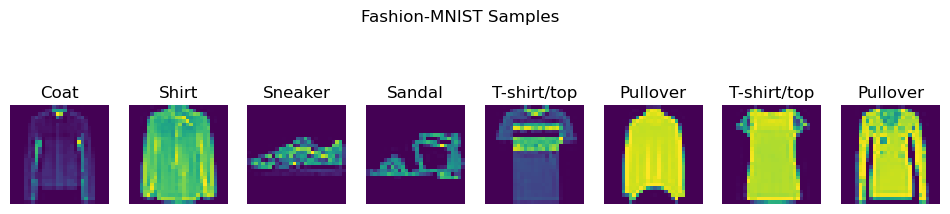

In [10]:
import matplotlib.pyplot as plt

# Get a batch
images, labels = next(iter(train_loader))

# Unnormalize for display
images = images * 0.5 + 0.5  # Rescale back to [0, 1]

# Plot 8 samples
plt.figure(figsize=(12, 3))
for i in range(8):
    plt.subplot(1, 8, i + 1)
    plt.imshow(images[i].squeeze())
    print(images[i].shape)
    plt.title(fashion_classes[labels[i]])
    plt.axis("off")
plt.suptitle("Fashion-MNIST Samples")
plt.show()

## Let's buid a simple GAN model

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np

# Basic GAN hyperparameters
batch_size = 128
latent_dim = 100           # Size of latent input z
hidden_dim = 512           # Number of neurons per layer
img_shape = (1, 28, 28)     # Fashion-MNIST: 64x64 RGB images
flattened_dim = int(np.prod(img_shape))
num_epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def dense_block(in_features, out_features, leak=0.2):
    """
    Returns a sequential block: Linear → LeakyReLU → LayerNorm
    """
    return nn.Sequential(
        nn.Linear(in_features, out_features),
        nn.LeakyReLU(leak),
        nn.LayerNorm(out_features)
    )

def build_simple_gan(latent_dim, hidden_dim, output_shape, leak=0.2):
    """
    Constructs a simple GAN architecture.

    Args:
        latent_dim: Dimension of the latent space (input to generator)
        hidden_dim: Number of hidden units in generator and discriminator
        output_shape: Output image shape (e.g., (1, 28, 28))
        leak: LeakyReLU negative slope
    Returns:
        G: Generator model
        D: Discriminator model
    """
    flat_output = int(np.prod(output_shape))

    # Generator: z → image
    G = nn.Sequential(
        dense_block(latent_dim, hidden_dim),
        dense_block(hidden_dim, hidden_dim),
        nn.Linear(hidden_dim, flat_output),
        nn.Tanh(),                         # Output in [-1, 1]
        nn.Unflatten(1, output_shape)      # Shape to (B, 1, 28, 28)
    )

    # Discriminator: image → 0/1
    D = nn.Sequential(
        nn.Flatten(),
        dense_block(flat_output, hidden_dim),
        dense_block(hidden_dim, hidden_dim),
        nn.Linear(hidden_dim, 1),
        nn.Sigmoid()                       # Output probability
    )

    return G.to(device), D.to(device)

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

# --------------------------------------------
# 1. Load Fashion-MNIST with normalization
# --------------------------------------------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1] for tanh
])

train_dataset = datasets.FashionMNIST(
    root='./data',
    train=True,
    transform=transform,
    download=True
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# --------------------------------------------
# 2. Build models and loss
# --------------------------------------------
G, D = build_simple_gan(latent_dim, hidden_dim, img_shape)

loss_fn = nn.BCELoss()  # Binary Cross-Entropy Loss

# --------------------------------------------
# 3. Define optimizers
# --------------------------------------------
G_opt = optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))
D_opt = optim.Adam(D.parameters(), lr=2e-4, betas=(0.5, 0.999))

# --------------------------------------------
# 4. Track losses for visualization
# --------------------------------------------
G_losses = []
D_losses = []

# --------------------------------------------
# 5. Training loop
# --------------------------------------------
for epoch in range(num_epochs):
    G.train()
    D.train()
    total_G_loss = 0.0
    total_D_loss = 0.0

    for real_imgs, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size(0)

        # ===============================
        # Train Discriminator: maximize log(D(x)) + log(1 - D(G(z)))
        # ===============================
        D.zero_grad()

        # Real labels (1s), Fake labels (0s)
        y_real = torch.ones(batch_size, 1, device=device)
        y_fake = torch.zeros(batch_size, 1, device=device)

        # Compute D loss on real images
        d_real_loss = loss_fn(D(real_imgs), y_real)

        # Generate fake images and detach (don't update G yet)
        z = torch.randn(batch_size, latent_dim, device=device)
        fake_imgs = G(z).detach()  # No gradients to G
        d_fake_loss = loss_fn(D(fake_imgs), y_fake)

        # Total D loss
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        D_opt.step()

        # ===============================
        # Train Generator: maximize log(D(G(z)))
        # ===============================
        G.zero_grad()

        # Generate new batch of fake images
        z = torch.randn(batch_size, latent_dim, device=device)
        gen_imgs = G(z)

        # We want discriminator to believe these are real → label = 1
        g_loss = loss_fn(D(gen_imgs), y_real)

        g_loss.backward()
        G_opt.step()

        # Track losses
        total_D_loss += d_loss.item()
        total_G_loss += g_loss.item()

    avg_D_loss = total_D_loss / len(train_loader)
    avg_G_loss = total_G_loss / len(train_loader)

    D_losses.append(avg_D_loss)
    G_losses.append(avg_G_loss)

    print(f"Epoch {epoch+1:02d} | D Loss: {avg_D_loss:.4f} | G Loss: {avg_G_loss:.4f}")

Epoch 1/100: 100%|██████████| 469/469 [00:07<00:00, 62.34it/s]


Epoch 01 | D Loss: 0.5909 | G Loss: 2.1266


Epoch 2/100: 100%|██████████| 469/469 [00:06<00:00, 67.17it/s]


Epoch 02 | D Loss: 0.8044 | G Loss: 1.8593


Epoch 3/100: 100%|██████████| 469/469 [00:07<00:00, 64.64it/s]


Epoch 03 | D Loss: 0.8616 | G Loss: 1.6712


Epoch 4/100: 100%|██████████| 469/469 [00:07<00:00, 61.81it/s]


Epoch 04 | D Loss: 0.8568 | G Loss: 1.6238


Epoch 5/100: 100%|██████████| 469/469 [00:07<00:00, 65.81it/s]


Epoch 05 | D Loss: 0.8392 | G Loss: 1.6574


Epoch 6/100: 100%|██████████| 469/469 [00:07<00:00, 64.46it/s]


Epoch 06 | D Loss: 0.8410 | G Loss: 1.6465


Epoch 7/100: 100%|██████████| 469/469 [00:07<00:00, 60.28it/s]


Epoch 07 | D Loss: 0.8426 | G Loss: 1.6422


Epoch 8/100: 100%|██████████| 469/469 [00:08<00:00, 55.24it/s]


Epoch 08 | D Loss: 0.8459 | G Loss: 1.6191


Epoch 9/100: 100%|██████████| 469/469 [00:07<00:00, 61.85it/s]


Epoch 09 | D Loss: 0.8552 | G Loss: 1.5889


Epoch 10/100: 100%|██████████| 469/469 [00:07<00:00, 63.80it/s]


Epoch 10 | D Loss: 0.8588 | G Loss: 1.5595


Epoch 11/100: 100%|██████████| 469/469 [00:07<00:00, 64.69it/s]


Epoch 11 | D Loss: 0.8633 | G Loss: 1.5481


Epoch 12/100: 100%|██████████| 469/469 [00:07<00:00, 59.73it/s]


Epoch 12 | D Loss: 0.8602 | G Loss: 1.5500


Epoch 13/100: 100%|██████████| 469/469 [00:07<00:00, 63.01it/s]


Epoch 13 | D Loss: 0.8612 | G Loss: 1.5440


Epoch 14/100: 100%|██████████| 469/469 [00:07<00:00, 65.19it/s]


Epoch 14 | D Loss: 0.8629 | G Loss: 1.5517


Epoch 15/100: 100%|██████████| 469/469 [00:07<00:00, 60.37it/s]


Epoch 15 | D Loss: 0.8574 | G Loss: 1.5479


Epoch 16/100: 100%|██████████| 469/469 [00:08<00:00, 56.04it/s]


Epoch 16 | D Loss: 0.8587 | G Loss: 1.5533


Epoch 17/100: 100%|██████████| 469/469 [00:08<00:00, 58.32it/s]


Epoch 17 | D Loss: 0.8595 | G Loss: 1.5416


Epoch 18/100: 100%|██████████| 469/469 [00:07<00:00, 60.85it/s]


Epoch 18 | D Loss: 0.8604 | G Loss: 1.5555


Epoch 19/100: 100%|██████████| 469/469 [00:07<00:00, 63.59it/s]


Epoch 19 | D Loss: 0.8607 | G Loss: 1.5469


Epoch 20/100: 100%|██████████| 469/469 [00:07<00:00, 61.48it/s]


Epoch 20 | D Loss: 0.8607 | G Loss: 1.5432


Epoch 21/100: 100%|██████████| 469/469 [00:07<00:00, 60.55it/s]


Epoch 21 | D Loss: 0.8616 | G Loss: 1.5362


Epoch 22/100: 100%|██████████| 469/469 [00:07<00:00, 62.49it/s]


Epoch 22 | D Loss: 0.8613 | G Loss: 1.5305


Epoch 23/100: 100%|██████████| 469/469 [00:07<00:00, 62.16it/s]


Epoch 23 | D Loss: 0.8619 | G Loss: 1.5303


Epoch 24/100: 100%|██████████| 469/469 [00:07<00:00, 62.41it/s]


Epoch 24 | D Loss: 0.8589 | G Loss: 1.5466


Epoch 25/100: 100%|██████████| 469/469 [00:07<00:00, 63.97it/s]


Epoch 25 | D Loss: 0.8589 | G Loss: 1.5418


Epoch 26/100: 100%|██████████| 469/469 [00:07<00:00, 64.31it/s]


Epoch 26 | D Loss: 0.8588 | G Loss: 1.5454


Epoch 27/100: 100%|██████████| 469/469 [00:07<00:00, 63.60it/s]


Epoch 27 | D Loss: 0.8584 | G Loss: 1.5444


Epoch 28/100: 100%|██████████| 469/469 [00:07<00:00, 63.19it/s]


Epoch 28 | D Loss: 0.8553 | G Loss: 1.5332


Epoch 29/100: 100%|██████████| 469/469 [00:07<00:00, 64.76it/s]


Epoch 29 | D Loss: 0.8567 | G Loss: 1.5400


Epoch 30/100: 100%|██████████| 469/469 [00:07<00:00, 63.99it/s]


Epoch 30 | D Loss: 0.8551 | G Loss: 1.5406


Epoch 31/100: 100%|██████████| 469/469 [00:07<00:00, 64.64it/s]


Epoch 31 | D Loss: 0.8528 | G Loss: 1.5541


Epoch 32/100: 100%|██████████| 469/469 [00:07<00:00, 64.10it/s]


Epoch 32 | D Loss: 0.8526 | G Loss: 1.5375


Epoch 33/100: 100%|██████████| 469/469 [00:07<00:00, 62.14it/s]


Epoch 33 | D Loss: 0.8518 | G Loss: 1.5655


Epoch 34/100: 100%|██████████| 469/469 [00:07<00:00, 64.45it/s]


Epoch 34 | D Loss: 0.8461 | G Loss: 1.5528


Epoch 35/100: 100%|██████████| 469/469 [00:07<00:00, 61.70it/s]


Epoch 35 | D Loss: 0.8457 | G Loss: 1.5607


Epoch 36/100: 100%|██████████| 469/469 [00:07<00:00, 63.16it/s]


Epoch 36 | D Loss: 0.8456 | G Loss: 1.5529


Epoch 37/100: 100%|██████████| 469/469 [00:07<00:00, 64.87it/s]


Epoch 37 | D Loss: 0.8415 | G Loss: 1.5582


Epoch 38/100: 100%|██████████| 469/469 [00:07<00:00, 63.50it/s]


Epoch 38 | D Loss: 0.8411 | G Loss: 1.5651


Epoch 39/100: 100%|██████████| 469/469 [00:07<00:00, 64.29it/s]


Epoch 39 | D Loss: 0.8388 | G Loss: 1.5758


Epoch 40/100: 100%|██████████| 469/469 [00:07<00:00, 63.12it/s]


Epoch 40 | D Loss: 0.8358 | G Loss: 1.5739


Epoch 41/100: 100%|██████████| 469/469 [00:07<00:00, 63.36it/s]


Epoch 41 | D Loss: 0.8312 | G Loss: 1.5880


Epoch 42/100: 100%|██████████| 469/469 [00:07<00:00, 64.11it/s]


Epoch 42 | D Loss: 0.8337 | G Loss: 1.5802


Epoch 43/100: 100%|██████████| 469/469 [00:07<00:00, 65.80it/s]


Epoch 43 | D Loss: 0.8326 | G Loss: 1.5873


Epoch 44/100: 100%|██████████| 469/469 [00:07<00:00, 65.46it/s]


Epoch 44 | D Loss: 0.8270 | G Loss: 1.5930


Epoch 45/100: 100%|██████████| 469/469 [00:07<00:00, 63.91it/s]


Epoch 45 | D Loss: 0.8252 | G Loss: 1.6117


Epoch 46/100: 100%|██████████| 469/469 [00:07<00:00, 64.54it/s]


Epoch 46 | D Loss: 0.8266 | G Loss: 1.5945


Epoch 47/100: 100%|██████████| 469/469 [00:07<00:00, 62.78it/s]


Epoch 47 | D Loss: 0.8235 | G Loss: 1.6084


Epoch 48/100: 100%|██████████| 469/469 [00:07<00:00, 63.44it/s]


Epoch 48 | D Loss: 0.8213 | G Loss: 1.6040


Epoch 49/100: 100%|██████████| 469/469 [00:07<00:00, 62.38it/s]


Epoch 49 | D Loss: 0.8165 | G Loss: 1.6227


Epoch 50/100: 100%|██████████| 469/469 [00:07<00:00, 61.56it/s]


Epoch 50 | D Loss: 0.8152 | G Loss: 1.6232


Epoch 51/100: 100%|██████████| 469/469 [00:07<00:00, 63.57it/s]


Epoch 51 | D Loss: 0.8149 | G Loss: 1.6244


Epoch 52/100: 100%|██████████| 469/469 [00:07<00:00, 61.85it/s]


Epoch 52 | D Loss: 0.8111 | G Loss: 1.6370


Epoch 53/100: 100%|██████████| 469/469 [00:07<00:00, 63.24it/s]


Epoch 53 | D Loss: 0.8070 | G Loss: 1.6433


Epoch 54/100: 100%|██████████| 469/469 [00:07<00:00, 64.06it/s]


Epoch 54 | D Loss: 0.8069 | G Loss: 1.6496


Epoch 55/100: 100%|██████████| 469/469 [00:07<00:00, 64.34it/s]


Epoch 55 | D Loss: 0.8018 | G Loss: 1.6463


Epoch 56/100: 100%|██████████| 469/469 [00:07<00:00, 65.15it/s]


Epoch 56 | D Loss: 0.8026 | G Loss: 1.6555


Epoch 57/100: 100%|██████████| 469/469 [00:07<00:00, 62.43it/s]


Epoch 57 | D Loss: 0.7966 | G Loss: 1.6599


Epoch 58/100: 100%|██████████| 469/469 [00:07<00:00, 62.87it/s]


Epoch 58 | D Loss: 0.7958 | G Loss: 1.6743


Epoch 59/100: 100%|██████████| 469/469 [00:07<00:00, 64.64it/s]


Epoch 59 | D Loss: 0.7945 | G Loss: 1.6756


Epoch 60/100: 100%|██████████| 469/469 [00:07<00:00, 65.37it/s]


Epoch 60 | D Loss: 0.7927 | G Loss: 1.6773


Epoch 61/100: 100%|██████████| 469/469 [00:07<00:00, 65.40it/s]


Epoch 61 | D Loss: 0.7872 | G Loss: 1.6822


Epoch 62/100: 100%|██████████| 469/469 [00:07<00:00, 63.69it/s]


Epoch 62 | D Loss: 0.7867 | G Loss: 1.6936


Epoch 63/100: 100%|██████████| 469/469 [00:07<00:00, 64.89it/s]


Epoch 63 | D Loss: 0.7852 | G Loss: 1.7024


Epoch 64/100: 100%|██████████| 469/469 [00:07<00:00, 63.55it/s]


Epoch 64 | D Loss: 0.7841 | G Loss: 1.6953


Epoch 65/100: 100%|██████████| 469/469 [00:07<00:00, 64.17it/s]


Epoch 65 | D Loss: 0.7750 | G Loss: 1.7183


Epoch 66/100: 100%|██████████| 469/469 [00:07<00:00, 63.84it/s]


Epoch 66 | D Loss: 0.7701 | G Loss: 1.7339


Epoch 67/100: 100%|██████████| 469/469 [00:07<00:00, 65.52it/s]


Epoch 67 | D Loss: 0.7734 | G Loss: 1.7379


Epoch 68/100: 100%|██████████| 469/469 [00:07<00:00, 65.42it/s]


Epoch 68 | D Loss: 0.7691 | G Loss: 1.7408


Epoch 69/100: 100%|██████████| 469/469 [00:07<00:00, 63.36it/s]


Epoch 69 | D Loss: 0.7677 | G Loss: 1.7514


Epoch 70/100: 100%|██████████| 469/469 [00:07<00:00, 66.22it/s]


Epoch 70 | D Loss: 0.7656 | G Loss: 1.7436


Epoch 71/100: 100%|██████████| 469/469 [00:07<00:00, 66.07it/s]


Epoch 71 | D Loss: 0.7677 | G Loss: 1.7505


Epoch 72/100: 100%|██████████| 469/469 [00:07<00:00, 62.07it/s]


Epoch 72 | D Loss: 0.7561 | G Loss: 1.7589


Epoch 73/100: 100%|██████████| 469/469 [00:07<00:00, 63.66it/s]


Epoch 73 | D Loss: 0.7579 | G Loss: 1.7750


Epoch 74/100: 100%|██████████| 469/469 [00:07<00:00, 65.50it/s]


Epoch 74 | D Loss: 0.7528 | G Loss: 1.7795


Epoch 75/100: 100%|██████████| 469/469 [00:07<00:00, 64.11it/s]


Epoch 75 | D Loss: 0.7518 | G Loss: 1.7882


Epoch 76/100: 100%|██████████| 469/469 [00:07<00:00, 65.15it/s]


Epoch 76 | D Loss: 0.7448 | G Loss: 1.8119


Epoch 77/100: 100%|██████████| 469/469 [00:06<00:00, 69.53it/s]


Epoch 77 | D Loss: 0.7385 | G Loss: 1.8187


Epoch 78/100: 100%|██████████| 469/469 [00:06<00:00, 69.91it/s]


Epoch 78 | D Loss: 0.7377 | G Loss: 1.8268


Epoch 79/100: 100%|██████████| 469/469 [00:06<00:00, 69.66it/s]


Epoch 79 | D Loss: 0.7345 | G Loss: 1.8220


Epoch 80/100: 100%|██████████| 469/469 [00:06<00:00, 70.23it/s]


Epoch 80 | D Loss: 0.7330 | G Loss: 1.8465


Epoch 81/100: 100%|██████████| 469/469 [00:06<00:00, 68.47it/s]


Epoch 81 | D Loss: 0.7333 | G Loss: 1.8510


Epoch 82/100: 100%|██████████| 469/469 [00:06<00:00, 68.60it/s]


Epoch 82 | D Loss: 0.7301 | G Loss: 1.8469


Epoch 83/100: 100%|██████████| 469/469 [00:06<00:00, 69.97it/s]


Epoch 83 | D Loss: 0.7236 | G Loss: 1.8542


Epoch 84/100: 100%|██████████| 469/469 [00:07<00:00, 66.96it/s]


Epoch 84 | D Loss: 0.7228 | G Loss: 1.8750


Epoch 85/100: 100%|██████████| 469/469 [00:06<00:00, 69.53it/s]


Epoch 85 | D Loss: 0.7189 | G Loss: 1.8767


Epoch 86/100: 100%|██████████| 469/469 [00:06<00:00, 70.09it/s]


Epoch 86 | D Loss: 0.7166 | G Loss: 1.8794


Epoch 87/100: 100%|██████████| 469/469 [00:06<00:00, 71.29it/s]


Epoch 87 | D Loss: 0.7171 | G Loss: 1.8952


Epoch 88/100: 100%|██████████| 469/469 [00:06<00:00, 69.85it/s]


Epoch 88 | D Loss: 0.7080 | G Loss: 1.8990


Epoch 89/100: 100%|██████████| 469/469 [00:06<00:00, 68.94it/s]


Epoch 89 | D Loss: 0.7081 | G Loss: 1.9227


Epoch 90/100: 100%|██████████| 469/469 [00:06<00:00, 68.97it/s]


Epoch 90 | D Loss: 0.7045 | G Loss: 1.9227


Epoch 91/100: 100%|██████████| 469/469 [00:06<00:00, 68.14it/s]


Epoch 91 | D Loss: 0.7031 | G Loss: 1.9397


Epoch 92/100: 100%|██████████| 469/469 [00:07<00:00, 62.09it/s]


Epoch 92 | D Loss: 0.7015 | G Loss: 1.9418


Epoch 93/100: 100%|██████████| 469/469 [00:08<00:00, 55.19it/s]


Epoch 93 | D Loss: 0.6979 | G Loss: 1.9426


Epoch 94/100: 100%|██████████| 469/469 [00:08<00:00, 55.10it/s]


Epoch 94 | D Loss: 0.6938 | G Loss: 1.9503


Epoch 95/100: 100%|██████████| 469/469 [00:07<00:00, 61.57it/s]


Epoch 95 | D Loss: 0.6898 | G Loss: 1.9662


Epoch 96/100: 100%|██████████| 469/469 [00:07<00:00, 61.35it/s]


Epoch 96 | D Loss: 0.6858 | G Loss: 1.9713


Epoch 97/100: 100%|██████████| 469/469 [00:07<00:00, 60.88it/s]


Epoch 97 | D Loss: 0.6849 | G Loss: 2.0010


Epoch 98/100: 100%|██████████| 469/469 [00:07<00:00, 58.65it/s]


Epoch 98 | D Loss: 0.6828 | G Loss: 2.0013


Epoch 99/100: 100%|██████████| 469/469 [00:07<00:00, 58.85it/s]


Epoch 99 | D Loss: 0.6793 | G Loss: 1.9954


Epoch 100/100: 100%|██████████| 469/469 [00:07<00:00, 59.32it/s]

Epoch 100 | D Loss: 0.6767 | G Loss: 2.0103


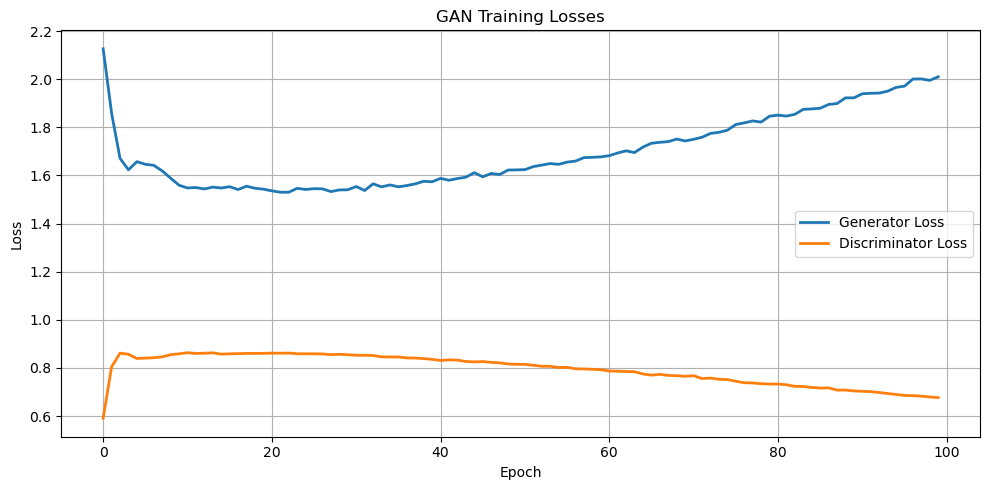

In [ ]:
# Plot both losses
plt.figure(figsize=(10, 5))
plt.plot(G_losses, label="Generator Loss", linewidth=2)
plt.plot(D_losses, label="Discriminator Loss", linewidth=2)
plt.title("GAN Training Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

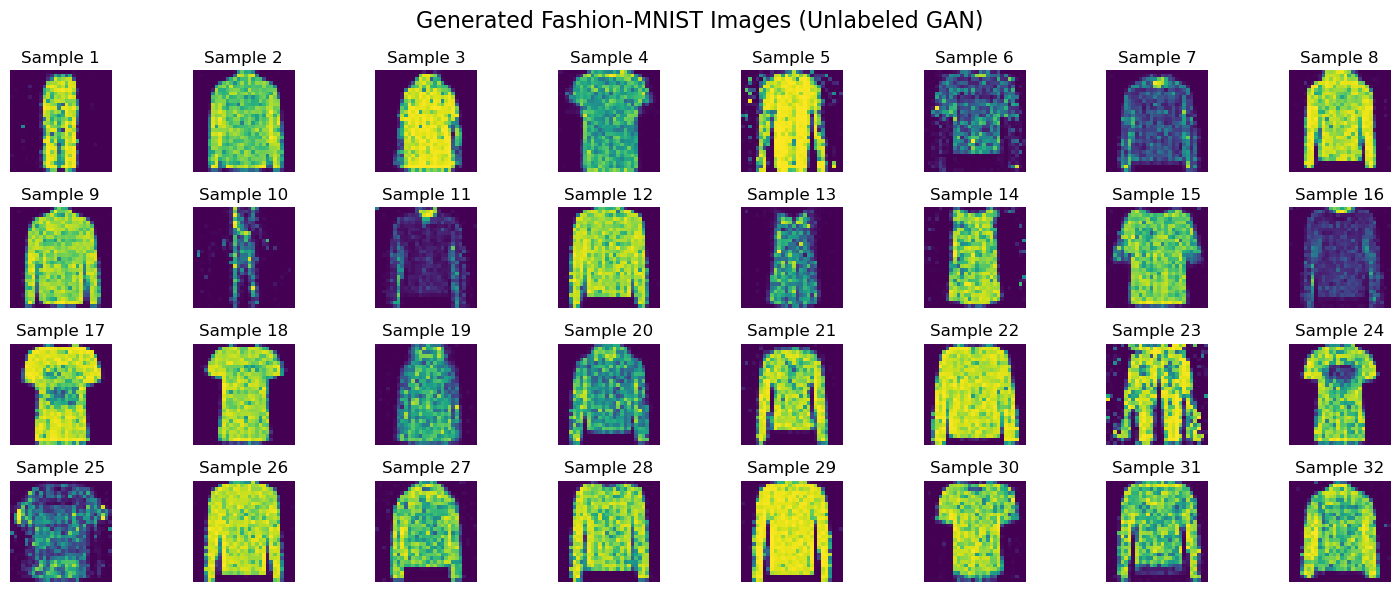

In [19]:
import matplotlib.pyplot as plt

# Fashion-MNIST labels
fashion_labels = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

# Set generator to eval mode
G.eval()

# Number of samples to generate
num_samples = 32
rows = 4
cols = num_samples // rows

with torch.no_grad():
    z = torch.randn(num_samples, latent_dim, device=device)
    fake_imgs = G(z).cpu()

# Denormalize from [-1, 1] to [0, 1] for display
fake_imgs = (fake_imgs + 1) / 2

# Plotting individual images with index (since GAN is not conditional)
fig, axs = plt.subplots(rows, cols, figsize=(15, 6))

for i, ax in enumerate(axs.flat):
    ax.imshow(fake_imgs[i].squeeze())
    ax.set_title(f"Sample {i+1}")
    ax.axis("off")

plt.suptitle("Generated Fashion-MNIST Images (Unlabeled GAN)", fontsize=16)
plt.tight_layout()
plt.show()


## **Mode Collapse** in GANs: What You're Seeing

In our GAN-generated Fashion-MNIST samples, we noticed that some classes like *sneakers* and *sandals* are missing entirely. This issue is a well-known phenomenon in GAN training called **mode collapse**.


### What Is Mode Collapse?

**Mode collapse** occurs when the generator learns to produce only a limited subset (or "mode") of the target distribution — ignoring the rest — because it discovers a shortcut that still fools the discriminator.

- Suppose the generator finds that generating only "shirts" consistently fools the discriminator.
- Then it may **only produce shirts**, ignoring sandals, sneakers, or coats — even though those are valid Fashion-MNIST classes.

Mathematically, instead of learning the full distribution $p_\text{data}(x)$, the generator $G(z)$ collapses to a smaller subspace:
$$
p_G(x) \approx \delta(x - x_0)
$$
where $x_0$ is a single mode (e.g., a shirt).


### Why Does This Happen?

- The generator receives no incentive to be **diverse**.
- If a few outputs successfully fool the discriminator, it may **reuse them**.
- The discriminator can become too powerful too quickly, leading to **vanishing gradients** for the generator.


### What’s Next?

In the next lecture, we will introduce **Wasserstein GANs (WGANs)** — a powerful approach to mitigating mode collapse.  
WGANs reformulate GAN training using the **Wasserstein distance**, providing:

- A smoother loss landscape,
- Better convergence,
- And significantly reduced mode collapse.
